<h3> Bounding Boxes </h3>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

In [9]:
files_in_dir = os.listdir()
dogcatimg = os.path.join(os.getcwd(),files_in_dir[1])
dogcatimg

'c:\\Users\\ASUS\\Desktop\\Hands on ML\\Hands-on-Machine-Learning-Textbook-Exercises\\DeepLearning_1\\Images\\dogcat.JPG'

In [10]:
dogcatimg_pixels = tf.io.decode_image(tf.io.read_file(dogcatimg))
#276,361,3

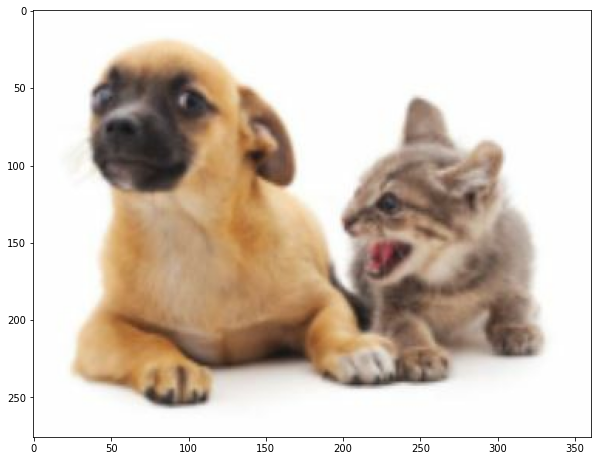

In [12]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(dogcatimg_pixels)

In [19]:
#upper_left, bottom_right
dog_box = [25.0,25.0,200.0,250.0]
cat_box = [200.0,50.0,330.0,225.0]

In [20]:
def box_corner_to_center(boxes):
    #upper_left
    x1 = boxes[0]
    y1 = boxes[1]
    #bottom_right
    x2 = boxes[2]
    y2 = boxes[3]
    centerx = (x1 + x2)/2
    centery = (y1 + y2)/2
    width = abs(x1 - x2)
    height = abs(y1 - y2)
    boxes = tf.stack((centerx,centery,width,height),axis = -1)
    return boxes

def box_center_to_corner(boxes):
    centerx = boxes[0]
    centery = boxes[1]
    width = boxes[2]
    height = boxes[3]
    #center to upper_left
    x1 = centerx - (width/2)
    y1 = centery - (height/2)
    #center to bottom_right
    x2 = centerx + width/2
    y2 = centery + (height/2)
    boxes = tf.stack((x1,y1,x2,y2),axis = -1)
    return boxes

In [21]:
boxes = tf.constant((dog_box,cat_box))
boxes

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 25.,  25., 200., 250.],
       [200.,  50., 330., 225.]], dtype=float32)>

In [22]:
center = tf.map_fn(box_corner_to_center,elems = boxes)
corners = tf.map_fn(box_center_to_corner,elems = center)

In [24]:
def box_to_rect(box,color):
    return plt.Rectangle(xy = (box[0],box[1]),width = box[2]-box[0],
                         height = box[3] - box[1],fill = False, edgecolor = color,linewidth = 2)

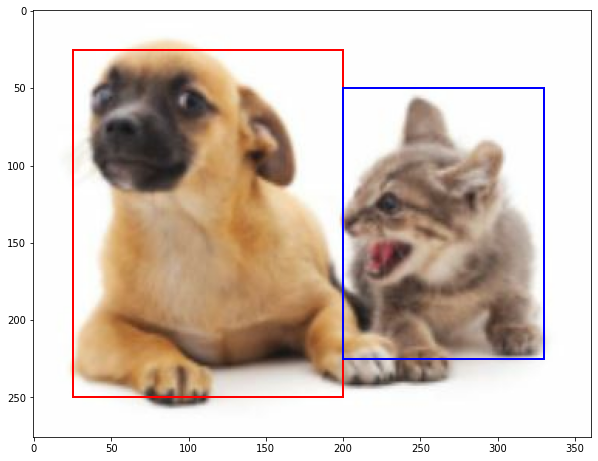

In [27]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(dogcatimg_pixels)
ax.add_patch(box_to_rect(dog_box,color = 'red'))
ax.add_patch(box_to_rect(cat_box,color = 'blue'))

<h3>Anchor Boxes</h3>

Object detection algorithms usually sample a large number of regions in an input image, determine whether these regions contain objects of interest and adjust the boundaries of the regions so as to predict the **ground truth bounding boxes** of the objects more accurately. 

There are different region sampling methods. Here we generate multiple bounding boxes with varying scales and aspect ratios centered on each pixel.

<h3>Generating multiple anchor boxes</h3>

Suppose the input image has a height of h and width of w. We generate anchor boxes with different shapes centered on each pixel. Scale (s) is between 0 to 1 and the aspect ratio(r)(ratio of width to height) is greater than 0. Width and height of the boxes are (ws(sqrt(r))) and (hs/(sqrt(r))). 

To generate multiple anchor boxes, we set up a series of scales s, and a series of aspect ratios r.

In [ ]:
#generate multiple anchor boxes
def mutibox_prior(data,sizes,ratios):
    #size and ratios are user specified
    in_height,in_width = data.shape[1],data.shape[2]
    devide,num_sizes,num_ratios = data.device,len(sizes),len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = tf.identity(sizes)
    ratios_tensor = tf.identity(ratios)

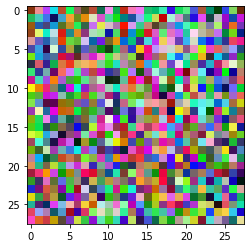

In [35]:

test = tf.random.uniform(shape =(1, 28, 28, 3))
plt.imshow(test[0])

In [48]:
tf.identity([1,2,3,4]).device

'/job:localhost/replica:0/task:0/device:GPU:0'

In [44]:
test.device

'/job:localhost/replica:0/task:0/device:GPU:0'